Este colab fue adaptado por Arnold Charry Armero.

# Modelo SARIMA - Pronósticos

SARIMA es un método de pronósticos avanzado, el cual es una extensión del modelo ARIMA. Incluye ahora cuatro modelos dentro de sí mismo para entrar a dar una predicción; estos son, **Estacionalidad (S), Autoregresión (AR), Integración (I) y Promedio Móvil (MA)**. El modelo ARIMA presenta problemas cuando en los datos de entrenamiento se presenta estacionalidad, ya que en este modelo dentro de sus hiperparámetros sólo se toma en cuenta la tendencia. Por lo tanto, con el fin de arreglar este problema, se agregan cuatro parámetros más dentro del modelo de estacionalidad para saber en que periodos del ciclo hay un determinado patrón de demanda. Estos parámetros e hiperparámetros son los siguientes:



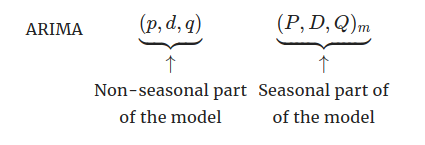

**Nota:** La estructura matemática de este modelo es más compleja que los primeros pronósticos y en este colab el enfoque será solo utilizar librerias para realizar las predicciones. En cursos de Machine Learning y Big Data se profundiza en el modelo matemático.

In [1]:
#Se instala el método
!pip install statsmodels
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.8 MB/s eta 0:00:00


In [2]:
#Se importan las librerias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

In [5]:
#Conectamos con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
#Se ingresa la base de datos
df = pd.read_csv('/content/drive/MyDrive/electricity_data.csv')
df.head(10)

,Date,United States : all sectors,United States : electric utility,United States : independent power producers,United States : all commercial,United States : all industrial,New England : all sectors,New England : electric utility,New England : independent power producers,New England : all commercial,New England : all industrial,Connecticut : all sectors,Connecticut : electric utility,Connecticut : independent power producers,Connecticut : all commercial,Connecticut : all industrial,Maine : all sectors,Maine : electric utility,Maine : independent power producers,Maine : all commercial,Maine : all industrial,Massachusetts : all sectors,Massachusetts : electric utility,Massachusetts : independent power producers,Massachusetts : all commercial,Massachusetts : all industrial,New Hampshire : all sectors,New Hampshire : electric utility,New Hampshire : independent power producers,New Hampshire : all commercial,New Hampshire : all industrial,Rhode Island : all sectors,Rhode Island : electric utility,Rhode Island : independent power producers,Rhode Island : all commercial,Rhode Island : all industrial,Vermont : all sectors,Vermont : electric utility,Vermont : independent power producers,Vermont : all commercial,Vermont : all industrial,Middle Atlantic : all sectors,Middle Atlantic : electric utility,Middle Atlantic : independent power producers,Middle Atlantic : all commercial,Middle Atlantic : all industrial,New Jersey : all sectors,New Jersey : electric utility,New Jersey : independent power producers,New Jersey : all commercial,New Jersey : all industrial,New York : all sectors,New York : electric utility,New York : independent power producers,New York : all commercial,New York : all industrial,Pennsylvania : all sectors,Pennsylvania : electric utility,Pennsylvania : independent power producers,Pennsylvania : all commercial,Pennsylvania : all industrial,East North Central : all sectors,East North Central : electric utility,East North Central : independent power producers,East North Central : all commercial,East North Central : all industrial,Illinois : all sectors,Illinois : electric utility,Illinois : independent power producers,Illinois : all commercial,Illinois : all industrial,Indiana : all sectors,Indiana : electric utility,Indiana : independent power producers,Indiana : all commercial,Indiana : all industrial,Michigan : all sectors,Michigan : electric utility,Michigan : independent power producers,Michigan : all commercial,Michigan : all industrial,Ohio : all sectors,Ohio : electric utility,Ohio : independent power producers,Ohio : all commercial,Ohio : all industrial,Wisconsin : all sectors,Wisconsin : electric utility,Wisconsin : independent power producers,Wisconsin : all commercial,Wisconsin : all industrial,West North Central : all sectors,West North Central : electric utility,West North Central : independent power producers,West North Central : all commercial,West North Central : all industrial,Iowa : all sectors,Iowa : electric utility,Iowa : independent power producers,Iowa : all commercial,Iowa : all industrial,Kansas : all sectors,Kansas : electric utility,Kansas : independent power producers,Kansas : all commercial,Kansas : all industrial,Minnesota : all sectors,Minnesota : electric utility,Minnesota : independent power producers,Minnesota : all commercial,Minnesota : all industrial,Missouri : all sectors,Missouri : electric utility,Missouri : independent power producers,Missouri : all commercial,Missouri : all industrial,Nebraska : all sectors,Nebraska : electric utility,Nebraska : independent power producers,Nebraska : all commercial,Nebraska : all industrial,North Dakota : all sectors,North Dakota : electric utility,North Dakota : independent power producers,North Dakota : all commercial,North Dakota : all industrial,South Dakota : all sectors,South Dakota : electric utility,South Dakota : independent power producers,South Dakota : all commercial,South Dakota : all industrial,South Atlantic : all sectors,South At

In [66]:
#Se pasa al formato de series de tiempo
df["Date"] = pd.to_datetime(df.iloc[:, 0], format = '%Y/%m/%d')
df.head(10)

,Date,United States : all sectors,United States : electric utility,United States : independent power producers,United States : all commercial,United States : all industrial,New England : all sectors,New England : electric utility,New England : independent power producers,New England : all commercial,New England : all industrial,Connecticut : all sectors,Connecticut : electric utility,Connecticut : independent power producers,Connecticut : all commercial,Connecticut : all industrial,Maine : all sectors,Maine : electric utility,Maine : independent power producers,Maine : all commercial,Maine : all industrial,Massachusetts : all sectors,Massachusetts : electric utility,Massachusetts : independent power producers,Massachusetts : all commercial,Massachusetts : all industrial,New Hampshire : all sectors,New Hampshire : electric utility,New Hampshire : independent power producers,New Hampshire : all commercial,New Hampshire : all industrial,Rhode Island : all sectors,Rhode Island : electric utility,Rhode Island : independent power producers,Rhode Island : all commercial,Rhode Island : all industrial,Vermont : all sectors,Vermont : electric utility,Vermont : independent power producers,Vermont : all commercial,Vermont : all industrial,Middle Atlantic : all sectors,Middle Atlantic : electric utility,Middle Atlantic : independent power producers,Middle Atlantic : all commercial,Middle Atlantic : all industrial,New Jersey : all sectors,New Jersey : electric utility,New Jersey : independent power producers,New Jersey : all commercial,New Jersey : all industrial,New York : all sectors,New York : electric utility,New York : independent power producers,New York : all commercial,New York : all industrial,Pennsylvania : all sectors,Pennsylvania : electric utility,Pennsylvania : independent power producers,Pennsylvania : all commercial,Pennsylvania : all industrial,East North Central : all sectors,East North Central : electric utility,East North Central : independent power producers,East North Central : all commercial,East North Central : all industrial,Illinois : all sectors,Illinois : electric utility,Illinois : independent power producers,Illinois : all commercial,Illinois : all industrial,Indiana : all sectors,Indiana : electric utility,Indiana : independent power producers,Indiana : all commercial,Indiana : all industrial,Michigan : all sectors,Michigan : electric utility,Michigan : independent power producers,Michigan : all commercial,Michigan : all industrial,Ohio : all sectors,Ohio : electric utility,Ohio : independent power producers,Ohio : all commercial,Ohio : all industrial,Wisconsin : all sectors,Wisconsin : electric utility,Wisconsin : independent power producers,Wisconsin : all commercial,Wisconsin : all industrial,West North Central : all sectors,West North Central : electric utility,West North Central : independent power producers,West North Central : all commercial,West North Central : all industrial,Iowa : all sectors,Iowa : electric utility,Iowa : independent power producers,Iowa : all commercial,Iowa : all industrial,Kansas : all sectors,Kansas : electric utility,Kansas : independent power producers,Kansas : all commercial,Kansas : all industrial,Minnesota : all sectors,Minnesota : electric utility,Minnesota : independent power producers,Minnesota : all commercial,Minnesota : all industrial,Missouri : all sectors,Missouri : electric utility,Missouri : independent power producers,Missouri : all commercial,Missouri : all industrial,Nebraska : all sectors,Nebraska : electric utility,Nebraska : independent power producers,Nebraska : all commercial,Nebraska : all industrial,North Dakota : all sectors,North Dakota : electric utility,North Dakota : independent power producers,North Dakota : all commercial,North Dakota : all industrial,South Dakota : all sectors,South Dakota : electric utility,South Dakota : independent power producers,South Dakota : all commercial,South Dakota : all industrial,South Atlantic : all sectors,South At

In [67]:
#Nos aseguramos de ver todo el contenido
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [68]:
df = df[['Date', 'United States : all sectors']]
df

,Date,United States : all sectors
0,2001-01-01,332493
1,2001-02-01,282940
2,2001-03-01,300707
3,2001-04-01,278079
4,2001-05-01,300492
5,2001-06-01,327694
6,2001-07-01,357614
7,2001-08-01,370533
8,2001-09-01,306929
9,2001-10-01,294734


In [69]:
df.rename(columns = {'United States : all sectors':'Electrical Demand in US'}, inplace = True)
df

,Date,Electrical Demand in US
0,2001-01-01,332493
1,2001-02-01,282940
2,2001-03-01,300707
3,2001-04-01,278079
4,2001-05-01,300492
5,2001-06-01,327694
6,2001-07-01,357614
7,2001-08-01,370533
8,2001-09-01,306929
9,2001-10-01,294734


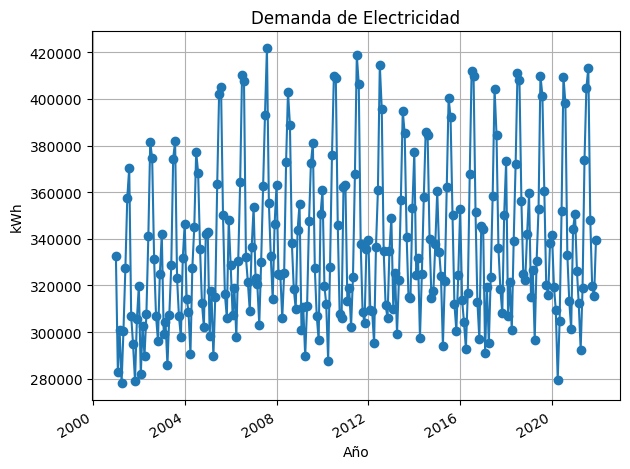

In [70]:
#Se realiza el gráfico de los datos
plt.plot_date(df.iloc[:, 0], df.iloc[:, 1], linestyle = 'solid')
plt.gcf().autofmt_xdate()

plt.title("Demanda de Electricidad")
plt.xlabel("Año")
plt.ylabel("kWh")

plt.grid()
plt.tight_layout()
plt.show()

## Pronósticos con SARIMA


### Modelo SARIMA

Primero se comprueba si la base de datos tiene estacionariedad. Posteriormente, se procede a realizar el pronóstico con la libreria de StatsModels.

In [71]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [72]:
#Se comprueba si tiene estacionariedad
adf_test(df.iloc[:, 1])

1. ADF :  -3.6968690772438144
2. P-Value :  0.004157409522887127
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 237
5. Critical Values :
	 1% :  -3.4582467982399105
	 5% :  -2.8738137461081323
	 10% :  -2.5733111490323846


El P-Valor debe ser menor a 0.05 para considerar que tiene estacionariedad. De lo contrario, no la posee. En este caso en concreto, el P-Valor es 0.004, lo cual es menor a 0.05. Por lo tanto, se posee estacionariedad.

In [73]:
#Ignorar advertencias
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [74]:
#Análisis de la base de datos
stepwise_fit = auto_arima(df.iloc[:, 1],
                      seasonal=True,
                      test='adf',
                      m=12,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5620.200, Time=3.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5982.462, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5744.423, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5747.335, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7134.109, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=5656.983, Time=0.80 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=5629.759, Time=1.26 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=6.91 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=5768.539, Time=0.25 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=5632.715, Time=2.52 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=5631.641, Time=3.89 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=7.59 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  252
Model:             SARIMAX(3, 0, 4)x(1, 0, [], 12)   Log Likelihood               -2776.903
Date:                             Mon, 12 Feb 2024   AIC                           5573.805
Time:                                     00:23:37   BIC                           5609.099
Sample:                                          0   HQIC                          5588.007
                                             - 252                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.613e+05   1.53e-05   3.02e+10      0.000    4.61e+05    4.61e+05
ar.L1         -2.0589      0.501     -4.110      0.000      -3.041      -1.077
ar.L2         -1.9733      0.594     -3.320      0.001      -3.138      -0.808
ar.L3         -0.8800      0.473     -1.861      0.063      -1.807       0.047
ma.L1          2.5845      0.530      4.877      0.000       1.546       3.623
ma.L2          3.1250      0.922      3.389      0.001       1.318       4.932
ma.L3          2.0417      0.892      2.289      0.022       0.294       3.790
ma.L4          0.5160      0.338      1.525      0.127      -0.147       1.179
ar.S.L12       0.7685      0.061     12.612      0.000       0.649       0.888
sigma2      3.942e+08   5.92e-09   6.66e+16      0.000    3.94e+08    3.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.39   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.07   Prob(JB):                         0.63
Heteroskedasticity (H):               0.95   Skew:                             0.14
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.79e+32. Standard errors may be unstable.
"""

In [75]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(252, 2)
(222, 2) (30, 2)
Date                       2019-07-01 00:00:00
Electrical Demand in US                 410038
Name: 222, dtype: object Date                       2021-12-01 00:00:00
Electrical Demand in US                 339684
Name: 251, dtype: object


In [76]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Electrical Demand in US'], order = (3, 0, 4), seasonal_order = (1, 0, 0, 12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:           Electrical Demand in US   No. Observations:                  252
Model:             ARIMA(3, 0, 4)x(1, 0, [], 12)   Log Likelihood               -2776.995
Date:                           Mon, 12 Feb 2024   AIC                           5573.991
Time:                                   00:23:57   BIC                           5609.285
Sample:                                        0   HQIC                          5588.192
                                           - 252                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.367e+05   2.83e+04     11.900      0.000    2.81e+05    3.92e+05
ar.L1          1.7249      0.425      4.058

In [77]:
start=len(train)
end=len(train)+len(test)-1
df['Pronóstico SARIMA'] = model_fit.predict(start=start,end=end,typ='levels')
df

,Date,Electrical Demand in US,Pronóstico SARIMA
0,2001-01-01,332493,NaN
1,2001-02-01,282940,NaN
2,2001-03-01,300707,NaN
3,2001-04-01,278079,NaN
4,2001-05-01,300492,NaN
5,2001-06-01,327694,NaN
6,2001-07-01,357614,NaN
7,2001-08-01,370533,NaN
8,2001-09-01,306929,NaN
9,2001-10-01,294734,NaN


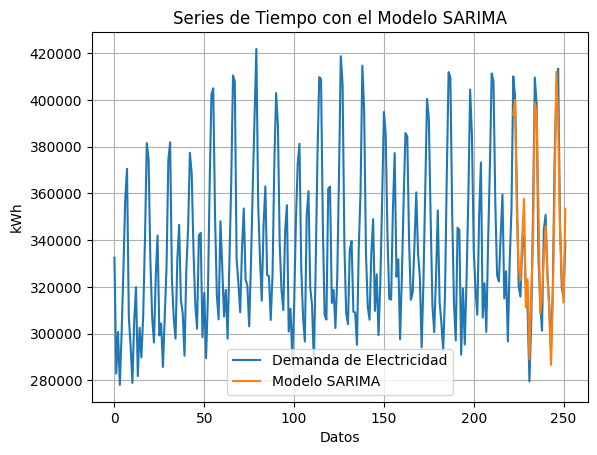

In [78]:
#Graficamos varios de los resultados
plt.plot(df.iloc[:, 1], label = 'Demanda de Electricidad')
plt.plot(df.iloc[:, 2], label = 'Modelo SARIMA')
plt.grid()
plt.legend(loc = 'best')
plt.title('Series de Tiempo con el Modelo SARIMA')
plt.xlabel("Datos")
plt.ylabel("kWh")
plt.show()

### Errores de Pronóstico

Para tener los errores, se comparan los valores reales de demanda con los valores pronosticados. De tal forma que se modela matemáticamente como,

$$ \mathrm{Error \: de \: Pronostico} = \begin{vmatrix}
\mathrm{Demanda \: Real} - \mathrm{Valor \: Pronosticado}
\end{vmatrix} $$

$$ \mathrm{Error \: de \: Pronostico} = \begin{vmatrix}
D_{t} - F_{t}
\end{vmatrix} $$

In [79]:
# Se calculan los errores

def Errores(number_column, forecast_column):
  """
  Calcula los errores tomando en cuenta los n valores anteriores

  Args:
    number_column: Número de la columna seleccionada del dataframe.
    forecast_column: Número de la columna en la que se hizo el pronóstico.
  Returns:
    Errors: lista con los errores de los respectivos pronósticos.
  """

  Errors = []
  l = len(df.iloc[:, number_column])

  for i in range(l):
    Error = np.abs(df.iloc[i, number_column] - df.iloc[i, forecast_column])
    Errors.append(Error)

  return Errors

In [80]:
df.insert(loc = 3, column = "Errores (OPI Función)", value = Errores(1, 2))
df

,Date,Electrical Demand in US,Pronóstico SARIMA,Errores (OPI Función)
0,2001-01-01,332493,NaN,NaN
1,2001-02-01,282940,NaN,NaN
2,2001-03-01,300707,NaN,NaN
3,2001-04-01,278079,NaN,NaN
4,2001-05-01,300492,NaN,NaN
5,2001-06-01,327694,NaN,NaN
6,2001-07-01,357614,NaN,NaN
7,2001-08-01,370533,NaN,NaN
8,2001-09-01,306929,NaN,NaN
9,2001-10-01,294734,NaN,NaN


### MAD

Una medida muy importante utilizada para medir el error global de un tipo de pronóstico es el MAD, el cual es el promedio de los errores. Matemáticamente se define así:

$$ \mathrm{MAD} = \frac{\sum \begin{vmatrix}
\mathrm{Demanda \: Real} - \mathrm{Valor \: Pronosticado}
\end{vmatrix}}{n} $$

In [81]:
# Parámetros necesarios para la optimización
order_sarima = (3, 0, 4)
seasonal_order_sarima = (1, 0, 0, 12)

In [82]:
def MAD_SARIMA(n):
  """
  Calcula el MAD del Modelo SARIMA tomando en cuenta
  los n valores anteriores

  Args:
    n: Entero que indica los n valores anteriores tomados en cuenta
    para el pronóstico del término siguiente.

  Returns:
    MAD: Número float con la desviación absoluta media (MAD).
  """

  ARIMA_model = pd.DataFrame()
  from statsmodels.tsa.arima.model import ARIMA
  model = ARIMA(df.iloc[:, 1], order = order_sarima, seasonal_order = seasonal_order_sarima)
  model_fit = model.fit()

  start = n
  end = len(df.iloc[n:]) + n - 1
  ARIMA_model['Pronóstico ARIMA'] = model_fit.predict(start=start,end=end,typ='levels')

  Errors = []

  l = len(df.iloc[:, 1])
  Sum = 0

  for i in range(n, l):
    Error = np.abs(df.iloc[i, 1] - ARIMA_model.iloc[i - n, 0])
    Errors.append(Error)

  for i in range(len(Errors)):
    Sum += Errors[i]

  mad = Sum / len(Errors)

  return mad

In [87]:
#Calculamos el MAD
MAD_SARIMA(222)

9148.039977182827

### Optimización del $n$

Ahora bien, haciéndo uso de los conocimientos de Analítica I y Matemáticas Aplicadas I, se puede minimizar la función objetivo MAD para obtener el mínimo error.

$ \mathbf{f.o.} $
$$ \mathit{min} \: \: \mathrm{MAD} = \frac{\sum \begin{vmatrix}
\mathrm{Demanda \: Real} - \mathrm{Valor \: Pronosticado}
\end{vmatrix}}{n} $$

$ \mathbf{s.a.} $
$$ n <  N $$
donde,

$ N = \mathrm{Total \: de \: datos} $

In [84]:
#Ahora se va a buscar el n óptimo que minimiza el MAD
x = np.arange(2, len(df.iloc[:, 1]) - 2, 1)
y = [MAD_SARIMA(n) for n in x]

min = None

for i in range(len(y)):
  if min is None or min > y[i]:
    min = y[i]
    minx = x[i]

print("El mínimo MAD es de {} con un n de {}.".format(min, minx))

El mínimo MAD es de 6075.625302247019 con un n de 248.


### Referencias

*   8.9 Seasonal ARIMA models | Forecasting: Principles and Practice (2nd ed). (n.d.). https://otexts.com/fpp2/seasonal-arima.html
*   ARIMA and SARIMAX models with python. (n.d.). https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python
*   Bajaj, A. (2023, August 18). ARIMA & SARIMA: Real-World Time Series Forecasting. neptune.ai. https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide
*    Brownlee, J. (2019, August 21). A gentle introduction to SARIMA for time series forecasting in Python. MachineLearningMastery.com. https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
*   Data Heroes. (2022, August 1). Master Time Series Forecasting with SARIMA in Python [Video]. YouTube. https://www.youtube.com/watch?v=8yzVWoivCF4



